# Neural Architecture Search (Tensorflow/Keras2)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deephyper/tutorials/blob/main/tutorials/colab/NAS_basic.ipynb)

In this tutorial we will learn the basics of neural architecture search (NAS). We will use artificial data to simulate a regression problem. Then, we will discover how to create a neural architecture search space using conditions with the `deephyper.hpo` API. Finally, we will execute the search using Bayesian optimization and analyse the results.



In [1]:
!pip install "deephyper[tf-keras2,ray] pydot"

     |████████████████████████████████| 962 kB 5.1 MB/s 
     |████████████████████████████████| 4.2 MB 33.2 MB/s 
     |████████████████████████████████| 158 kB 47.4 MB/s 
     |████████████████████████████████| 102 kB 11.5 MB/s 
     |████████████████████████████████| 54.7 MB 23 kB/s 
     |████████████████████████████████| 118 kB 22.2 MB/s 
     |████████████████████████████████| 82 kB 213 kB/s 
     |████████████████████████████████| 3.0 MB 63.8 MB/s 
     |████████████████████████████████| 1.1 MB 46.6 MB/s 
     |████████████████████████████████| 201 kB 53.7 MB/s 
     |████████████████████████████████| 128 kB 75.8 MB/s 
     |████████████████████████████████| 65 kB 4.0 MB/s 
     |████████████████████████████████| 192 kB 64.4 MB/s 
     |████████████████████████████████| 271 kB 49.6 MB/s 
     |████████████████████████████████| 160 kB 57.6 MB/s 
     |████████████████████████████████| 85 kB 4.1 MB/s 
     |████████████████████████████████| 57 kB 4.7 MB/s 
  Created wheel for open

In [1]:
import pathlib
import os

WIDTH_PLOTS = 8
HEIGHT_PLOTS = WIDTH_PLOTS / 1.618

## Loading the data

First, we will create `load_data_*` functions which loads and returns the
training, validation and testing data. The `load_data_*` functions generates data from
a function $f(\mathbf{x}) = 2 \sin (x)$ where $x \in [-30, 30]$:

In [2]:
import numpy as np

from sklearn.model_selection import train_test_split

def load_data_train_test(random_state=42):
    rs = np.random.RandomState(random_state)

    train_size = 400
    f = lambda x: 2 * np.sin(x)  # a simlpe affine function

    x = rs.uniform(low=-30, high=30.0, size=train_size)
    y = f(x)

    x_tst = np.linspace(-30.0, 30.0, 400)
    y_tst = f(x_tst)

    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    x_tst = x_tst.reshape(-1, 1)
    y_tst = y_tst.reshape(-1, 1)

    return (x, y), (x_tst, y_tst)


def load_data_train_valid(verbose=0, random_state=42):

    (x, y), _ = load_data_train_test(random_state=random_state)

    train_X, valid_X, train_y, valid_y = train_test_split(
        x, y, test_size=0.33, random_state=random_state
    )

    if verbose:
        print(f"train_X shape: {np.shape(train_X)}")
        print(f"train_y shape: {np.shape(train_y)}")
        print(f"valid_X shape: {np.shape(valid_X)}")
        print(f"valid_y shape: {np.shape(valid_y)}")
    return (train_X, train_y), (valid_X, valid_y)

## Neural Architecture Search Space

In [3]:
from collections import deque

import tf_keras as tfk
import tf_keras.utils as tfku

from ConfigSpace import GreaterThanCondition
from deephyper.hpo import HpProblem


class SimpleMLPSearchSpace:

    def __init__(
        self, max_num_layers: int = 5, max_num_units_per_layer: int = 64
    ) -> None:
        self.max_num_layers = max_num_layers
        self.max_num_units_per_layer = max_num_units_per_layer
        self._hp_problem = None

    def create_model(self, parameters: dict) -> tfk.Model:
        """Create a tensorflow keras model from a set of hyperparameters."""

        tfk.backend.clear_session()

        inputs = out = tfk.layers.Input(shape=(1,), name="input")

        anchors = deque(maxlen=3)

        for i in range(parameters["num_layers"]):

            # Skip connection
            prev_out = out

            for anchor in anchors:
                if parameters[f"{anchor.name.split('/')[0]}->layer_{i}"]:

                    # Linear projection to match the shape of the output from the previous layer
                    anchor = tfk.layers.Dense(parameters[f"layer_{i-1}_units"])(anchor)
                    out = tfk.layers.Add()([out, anchor])
                    out = tfk.layers.Activation("relu")(out)

            # Dense layer for the main backbone of the model
            out = tfk.layers.Dense(
                parameters[f"layer_{i}_units"],
                activation=parameters[f"layer_{i}_activation"],
                name=f"layer_{i}",
            )(out)

            anchors.append(prev_out)

        # Final output layer with a single unit
        output = tfk.layers.Dense(1)(out)

        model = tfk.Model(inputs, output)

        return model

    @property
    def hp_problem(self) -> HpProblem:
        """Create a hyperparameter optimization problem corresponding to the model."""

        if self._hp_problem is not None:
            return self._hp_problem
        
        problem = HpProblem()

        max_num_layers = self.max_num_layers
        num_layers = problem.add_hyperparameter(
            (1, max_num_layers), "num_layers", default_value=2
        )

        anchors = deque(maxlen=3)

        conditions = []
        for i in range(max_num_layers):

            layer_i_units = problem.add_hyperparameter(
                (1, 64), f"layer_{i}_units", default_value=32
            )
            layer_i_activation = problem.add_hyperparameter(
                ["relu", "sigmoid", "tanh", "swish"],
                f"layer_{i}_activation",
                default_value="relu",
            )

            if i > 0:
                conditions.extend(
                    [
                        GreaterThanCondition(layer_i_units, num_layers, i),
                        GreaterThanCondition(layer_i_activation, num_layers, i),
                    ]
                )

            # For Skip Connections
            previous_layer = f"layer_{i-1}" if i > 0 else "input"

            for anchor_name in anchors:
                layer_i_connection = problem.add_hyperparameter(
                    (0, 1), f"{anchor_name}->layer_{i}", default_value=0
                )
                conditions.append(
                    GreaterThanCondition(layer_i_connection, num_layers, i)
                )

            anchors.append(previous_layer)

        problem.add_conditions(conditions)

        # Training hyperparameters
        problem.add_hyperparameter(
            (1e-5, 1e-1, "log-uniform"), "learning_rate", default_value=1e-3
        )
        problem.add_hyperparameter(
            (1, 100, "log-uniform"), "batch_size", default_value=16
        )

        self._hp_problem = problem
        
        return self._hp_problem

In [4]:
nas_search_space = SimpleMLPSearchSpace(max_num_layers=5, max_num_units_per_layer=64)
nas_search_space.hp_problem

Configuration space object:
  Hyperparameters:
    batch_size, Type: UniformInteger, Range: [1, 100], Default: 16, on log-scale
    input->layer_1, Type: UniformInteger, Range: [0, 1], Default: 0
    input->layer_2, Type: UniformInteger, Range: [0, 1], Default: 0
    input->layer_3, Type: UniformInteger, Range: [0, 1], Default: 0
    layer_0->layer_2, Type: UniformInteger, Range: [0, 1], Default: 0
    layer_0->layer_3, Type: UniformInteger, Range: [0, 1], Default: 0
    layer_0->layer_4, Type: UniformInteger, Range: [0, 1], Default: 0
    layer_0_activation, Type: Categorical, Choices: {relu, sigmoid, tanh, swish}, Default: relu
    layer_0_units, Type: UniformInteger, Range: [1, 64], Default: 32
    layer_1->layer_3, Type: UniformInteger, Range: [0, 1], Default: 0
    layer_1->layer_4, Type: UniformInteger, Range: [0, 1], Default: 0
    layer_1_activation, Type: Categorical, Choices: {relu, sigmoid, tanh, swish}, Default: relu
    layer_1_units, Type: UniformInteger, Range: [1, 64], 

In [5]:
nas_search_space.hp_problem.default_configuration

{'batch_size': 16,
 'layer_0_activation': 'relu',
 'layer_0_units': 32,
 'learning_rate': 0.001,
 'num_layers': 2,
 'input->layer_1': 0,
 'layer_1_activation': 'relu',
 'layer_1_units': 32,
 'input->layer_2': 0,
 'input->layer_3': 0,
 'layer_0->layer_2': 0,
 'layer_0->layer_3': 0,
 'layer_0->layer_4': 0,
 'layer_1->layer_3': 0,
 'layer_1->layer_4': 0,
 'layer_2->layer_4': 0,
 'layer_2_activation': 'relu',
 'layer_2_units': 1,
 'layer_3_activation': 'relu',
 'layer_3_units': 1,
 'layer_4_activation': 'relu',
 'layer_4_units': 1}

In [6]:
model = nas_search_space.create_model(nas_search_space.hp_problem.default_configuration)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1)]               0         
                                                                 
 layer_0 (Dense)             (None, 32)                64        
                                                                 
 layer_1 (Dense)             (None, 32)                1056      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1153 (4.50 KB)
Trainable params: 1153 (4.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


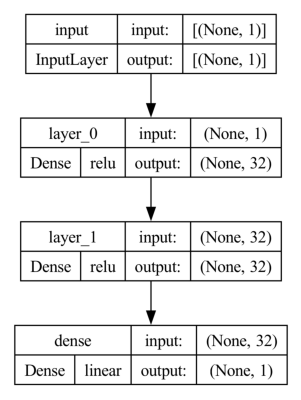

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def plot_model_architecture(model):
    plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
    tfku.plot_model(model, show_shapes=True, show_layer_names=True, show_layer_activations=True, dpi=300)
    image = mpimg.imread("model.png")
    plt.imshow(image)
    plt.axis("off")
    plt.show()

plot_model_architecture(model)

## Evaluation of Hyperparameters

In [8]:
from sklearn.preprocessing import StandardScaler


def run(job, model_checkpoint_dir=".", verbose=True, show_plots=False):
    if verbose:
        print(f"{job.id}: Start running...")

    (x, y), (vx, vy) = load_data_train_valid(verbose=verbose)
    _, (tx, ty) = load_data_train_test()

    if show_plots:
        plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))

        plt.plot(tx.reshape(-1), ty.reshape(-1), "ko--", label="test", alpha=0.5)
        plt.plot(x.reshape(-1), y.reshape(-1), "bo", label="train", alpha=0.8)
        plt.plot(vx.reshape(-1), vy.reshape(-1), "ro", label="valid", alpha=0.8)

        plt.ylabel("$y = f(x)$", fontsize=12)
        plt.xlabel("$x$", fontsize=12)

        plt.xlim(-30, 30)
        plt.legend(loc="upper center", ncol=3, fontsize=12)

        plt.show()

    # Scaling the data
    scaler_x = StandardScaler()
    s_x = scaler_x.fit_transform(x)
    s_vx = scaler_x.transform(vx)
    s_tx = scaler_x.transform(tx)

    scaler_y = StandardScaler()
    s_y = scaler_y.fit_transform(y)
    s_vy = scaler_y.transform(vy)
    s_ty = scaler_y.transform(ty)

    # Creating the model from received hyperparameters withing the `job`
    model = nas_search_space.create_model(job.parameters)

    # Some hyperparameters corresponds to training parameters
    # such as learning rate and batch size
    optimizer = tfk.optimizers.legacy.Adam(
        learning_rate=job.parameters["learning_rate"]
    )
    model.compile(optimizer, loss="mse")

    try:
        history = model.fit(
            s_x,
            s_y,
            epochs=1000,
            batch_size=job.parameters["batch_size"],
            validation_data=(s_vx, s_vy),
            verbose=verbose,
        )
    except:
        # Errors can happen during training de model (e.g., NaN values)
        # In this case we return a specific objective value starting with "F_"
        # To notify the search algorithm that these hyperparameters should be penalized.
        return "F_fit"

    # Checkpointing the model is useful to be able to reload it later
    # We use the `job.id` to give a unique identifier to the model
    tfk.models.save_model(
        model, os.path.join(model_checkpoint_dir, f"model_{job.id}.keras")
    )

    if show_plots:
        plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))

        plt.plot(history.history["loss"], label="training")
        plt.plot(history.history["val_loss"], label="validation")

        plt.xlabel("Epochs")
        plt.ylabel("MSE")

        plt.legend()

        plt.show()

    if show_plots:
        pred_ty = scaler_y.inverse_transform(model(s_tx).numpy())

        plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))

        plt.plot(tx, ty, label="truth")
        plt.plot(tx, pred_ty, label=r"$prediction$")

        plt.legend()
        plt.ylim(-30, 30)

        plt.show()

    # DeepHyper search algorithms are standardized for MAXIMIZATION
    # Therefore we return the negative of the validation loss at the last training iteration
    # Returning `-min(history.history["val_loss"])` is more prone to selecting overfitting models!
    return {"objective": -history.history["val_loss"][-1]}

## Testing the Baseline Default Neural Architecture

In [9]:
from deephyper.evaluator import RunningJob


def evaluate_baseline_default_neural_architecture():

    model_checkpoint_dir = "nas_tfk2_basic_baseline"
    pathlib.Path(model_checkpoint_dir).mkdir(parents=True, exist_ok=True)

    output = run(
        RunningJob(parameters=nas_search_space.hp_problem.default_configuration),
        model_checkpoint_dir=model_checkpoint_dir,
        verbose=True,
        show_plots=True,
    )
    return output

0.0: Start running...
train_X shape: (268, 1)
train_y shape: (268, 1)
valid_X shape: (132, 1)
valid_y shape: (132, 1)


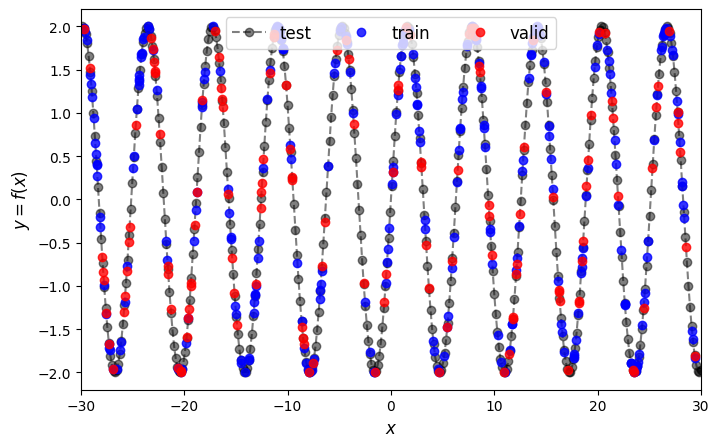

Epoch 1/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.0223 - val_loss: 0.8525
Epoch 2/1000
17/17 [==============================] - 0s 1ms/step - loss: 1.0018 - val_loss: 0.8364
Epoch 3/1000
17/17 [==============================] - 0s 1ms/step - loss: 1.0040 - val_loss: 0.8303
Epoch 4/1000
17/17 [==============================] - 0s 1ms/step - loss: 0.9995 - val_loss: 0.8424
Epoch 5/1000
17/17 [==============================] - 0s 1ms/step - loss: 0.9983 - val_loss: 0.8409
Epoch 6/1000
17/17 [==============================] - 0s 1ms/step - loss: 0.9969 - val_loss: 0.8346
Epoch 7/1000
17/17 [==============================] - 0s 3ms/step - loss: 0.9961 - val_loss: 0.8402
Epoch 8/1000
17/17 [==============================] - 0s 1ms/step - loss: 0.9937 - val_loss: 0.8332
Epoch 9/1000
17/17 [==============================] - 0s 1ms/step - loss: 0.9990 - val_loss: 0.8389
Epoch 10/1000
17/17 [==============================] - 0s 1ms/step - loss: 0.9913 - val_loss: 0.8360

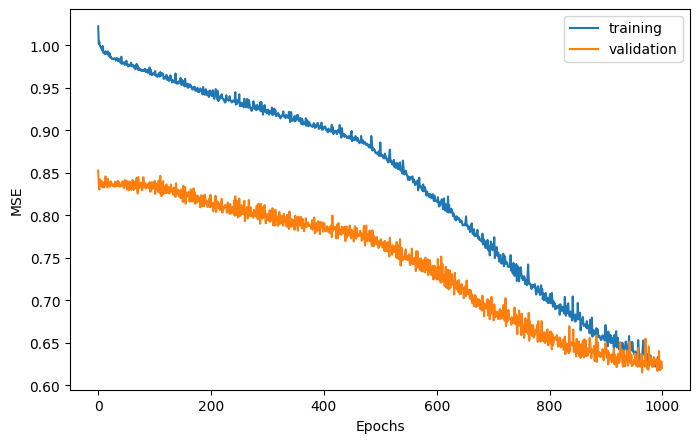

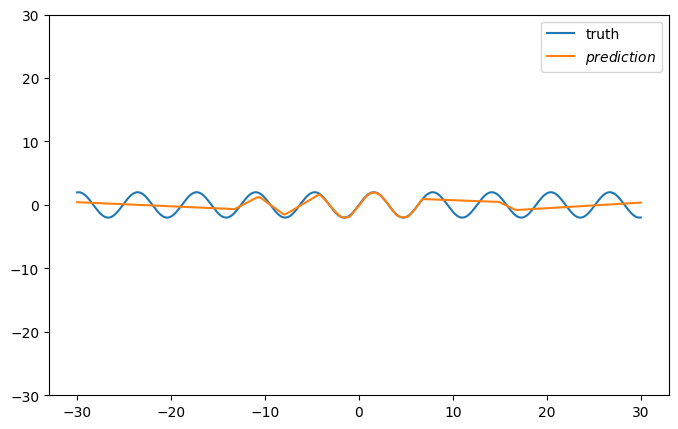

{'objective': -0.6206095814704895}

In [10]:
evaluate_baseline_default_neural_architecture()

## Executing Neural Architecture Search

In [12]:
from deephyper.hpo import CBO
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import TqdmCallback


def execute_neural_architecture_search():

    hpo_dir = "nas_tfk2_basic"
    model_checkpoint_dir = os.path.join(hpo_dir, "models")
    pathlib.Path(model_checkpoint_dir).mkdir(parents=True, exist_ok=True)

    evaluator = Evaluator.create(
        run,
        method="ray",
        method_kwargs={
            "num_cpus": 4,
            "num_cpus_per_task": 1,
            "run_function_kwargs": {
                "model_checkpoint_dir": model_checkpoint_dir,
                "verbose": False,
            },
            "callbacks": [TqdmCallback()],
        },
    )
    search = CBO(
        nas_search_space.hp_problem,
        evaluator,
        log_dir=hpo_dir,
        initial_points=[nas_search_space.hp_problem.default_configuration],
        acq_optimizer="mixedga",
        acq_optimizer_freq=1,
    )

    results = search.search(max_evals=50)

    return results

In [13]:
results = execute_neural_architecture_search()

2024-09-05 09:22:23,483	INFO worker.py:1788 -- Started a local Ray instance.
/Users/romainegele/Documents/Argonne/deephyper/deephyper/evaluator/_evaluator.py:132: UserWarning: Applying nest-asyncio patch for IPython Shell!
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

## Analyzing the Results of Neural Architecture Search

In [15]:
from deephyper.analysis.hpo import filter_failed_objectives


results, _ = filter_failed_objectives(results)
results

,p:batch_size,p:layer_0_activation,p:layer_0_units,p:learning_rate,p:num_layers,p:input->layer_1,p:input->layer_2,p:input->layer_3,p:layer_0->layer_2,p:layer_0->layer_3,...,p:layer_2_activation,p:layer_2_units,p:layer_3_activation,p:layer_3_units,p:layer_4_activation,p:layer_4_units,objective,job_id,m:timestamp_submit,m:timestamp_gather
0,44,sigmoid,45,0.032610,3,1,1,0,0,0,...,swish,33,relu,1,relu,1,-0.856591,2,2.398861,23.227373
1,35,swish,41,0.000015,3,1,0,0,0,0,...,relu,14,relu,1,relu,1,-0.837029,3,2.399569,25.287926
2,16,relu,32,0.001000,2,0,0,0,0,0,...,relu,1,relu,1,relu,1,-0.635702,0,2.397342,30.584927
3,74,relu,3,0.000054,5,1,0,0,1,0,...,tanh,31,relu,63,swish,56,-0.813391,4,24.227576,42.423346
4,38,sigmoid,4,0.003118,1,0,0,0,0,0,...,relu,1,relu,1,relu,1,-0.843133,6,31.686945,48.262753
5,15,swish,1,0.040829,2,0,0,0,0,0,...,relu,1,relu,1,relu,1,-0.878911,5,26.325039,49.630951
6,32,relu,21,0.010260,4,0,1,1,1,1,...,relu,4,sigmoid,57,relu,1,-0.552101,7,43.390739,65.487351
7,8,relu,41,0.003504,3,0,0,0,0,0,...,tanh,22,relu,1,relu,1,-0.393816,9,50.651295,91.581341
8,90,swish,41,0.004726,5,0,0,1,1,0,...,sigmoid,9,swish,3,sigmoid,13,-0.373598,11,92.546858,109.617554
9,8,swish,33,0.000012,4,1,0,1,1,1,...,relu,60,swish,64,relu,1,-0.835079,10,66.491044,121.362111


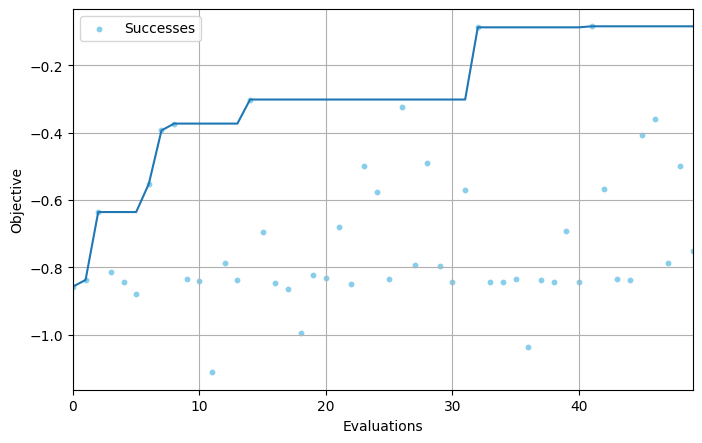

In [16]:
from deephyper.analysis.hpo import plot_search_trajectory_single_objective_hpo


fig, ax = plt.subplots(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
fig, ax = plot_search_trajectory_single_objective_hpo(results, ax=ax)
plt.show()

## Evaluate Checkpointed Models

In [23]:
def evaluate_checkpointed_model_on_test(model_path):

    print(f"Loading model: {model_path}")

    (x, y), (vx, vy) = load_data_train_valid(verbose=True)
    _, (tx, ty) = load_data_train_test()

    # Scaling the data
    scaler_x = StandardScaler()
    scaler_x.fit(x)
    s_tx = scaler_x.transform(tx)

    scaler_y = StandardScaler()
    scaler_y.fit(y)

    model = tfk.models.load_model(model_path)

    pred_ty = scaler_y.inverse_transform(model(s_tx).numpy())

    plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))

    plt.plot(tx, ty, label="truth")
    plt.plot(tx, pred_ty, label=r"$prediction$")

    plt.legend()
    plt.ylim(-30, 30)

    plt.show()

    plot_model_architecture(model)

parameters={'batch_size': 16, 'layer_0_activation': 'relu', 'layer_0_units': 32, 'learning_rate': 0.001, 'num_layers': 2, 'input->layer_1': 0, 'input->layer_2': 0, 'input->layer_3': 0, 'layer_0->layer_2': 0, 'layer_0->layer_3': 0, 'layer_0->layer_4': 0, 'layer_1->layer_3': 0, 'layer_1->layer_4': 0, 'layer_1_activation': 'relu', 'layer_1_units': 32, 'layer_2->layer_4': 0, 'layer_2_activation': 'relu', 'layer_2_units': 1, 'layer_3_activation': 'relu', 'layer_3_units': 1, 'layer_4_activation': 'relu', 'layer_4_units': 1}
Loading model: nas_tfk2_basic/models/model_0.0.keras
train_X shape: (268, 1)
train_y shape: (268, 1)
valid_X shape: (132, 1)
valid_y shape: (132, 1)


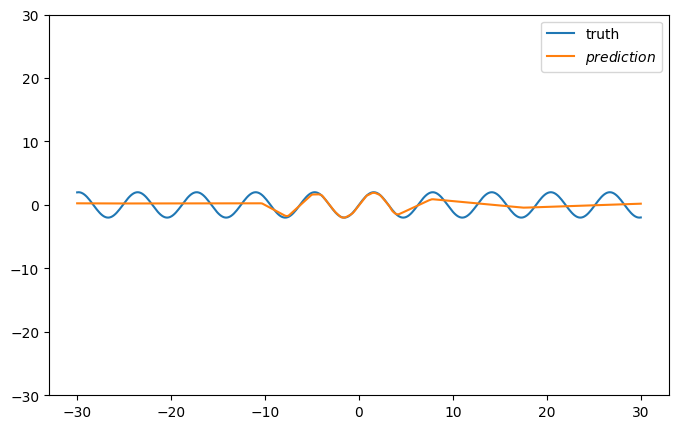

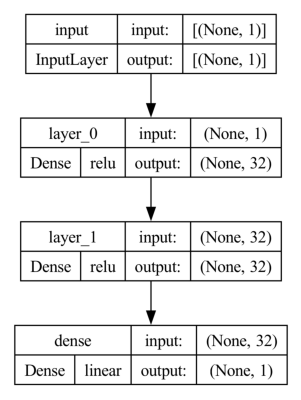

In [32]:
from deephyper.analysis.hpo import parameters_from_row


# Baseline model
idx = results["job_id"].argmin()
parameters = parameters_from_row(results.iloc[idx])
print(f"{parameters=}")

evaluate_checkpointed_model_on_test("nas_tfk2_basic/models/model_0.0.keras")

parameters={'batch_size': 14, 'layer_0_activation': 'relu', 'layer_0_units': 45, 'learning_rate': 0.001466675026, 'num_layers': 4, 'input->layer_1': 0, 'input->layer_2': 1, 'input->layer_3': 0, 'layer_0->layer_2': 0, 'layer_0->layer_3': 0, 'layer_0->layer_4': 0, 'layer_1->layer_3': 1, 'layer_1->layer_4': 0, 'layer_1_activation': 'swish', 'layer_1_units': 53, 'layer_2->layer_4': 0, 'layer_2_activation': 'tanh', 'layer_2_units': 23, 'layer_3_activation': 'tanh', 'layer_3_units': 11, 'layer_4_activation': 'relu', 'layer_4_units': 1}
Loading model: nas_tfk2_basic/models/model_0.42.keras
train_X shape: (268, 1)
train_y shape: (268, 1)
valid_X shape: (132, 1)
valid_y shape: (132, 1)


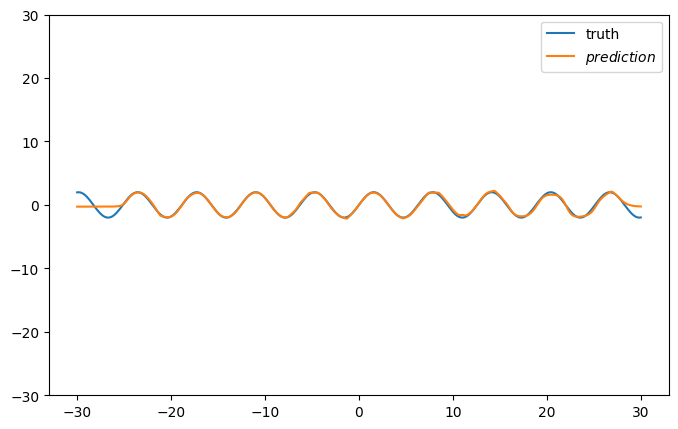

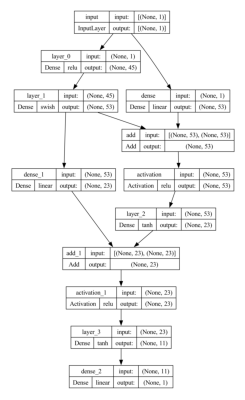

In [33]:
# Best model
idx = results["objective"].argmax()
job_id = results.iloc[idx]["job_id"]

parameters = parameters_from_row(results.iloc[idx])
print(f"{parameters=}")

evaluate_checkpointed_model_on_test(f"nas_tfk2_basic/models/model_0.{job_id}.keras")